In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv1D,Conv2D,BatchNormalization,Reshape,Activation,ReLU,Input,SimpleRNN,LSTM
from tensorflow.keras.metrics import MeanSquaredError,MeanAbsolutePercentageError,MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
import autoreload

from Network import *
%load_ext autoreload
%autoreload 2

## 数据集获取与数据预处理

In [3]:
def get_video_length(video_path):
    """
        给入视频路径，计算视频的长度以及FPS

        return:
        video_length:视频的长度，单位：s
        fps_counter：视频的帧率
    """
    video_capture = cv2.VideoCapture(video_path)

    frame_counter = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    fps_counter = video_capture.get(cv2.CAP_PROP_FPS)
    video_length = frame_counter/fps_counter

    video_capture.release()
    
    return video_length,fps_counter

def get_clip_hr_path_VIPL(cache_root_path,dataset_path):
    """
       获取所有clip以及HR路径
    """
#     without_glasses = [12,14,18,19,23,26,28,34,38,39,40,41,48,52,57,58,63,65,67,70,71,74,79,84,85,91,92,95,97,99]
    without_glasses = list(range(1,108))
    
    all_clip_path = []
    HR_gt_path = []
    for dirpath, dirnames, filenames in os.walk(cache_root_path):
        for dir in dirnames:
            if 'clip' in dir and int(dirpath.split("\\")[-2][1:]) in without_glasses:
                all_clip_path.append(os.path.join(dirpath,dir))  #  D:\ECNU\Graduation_Project\code\VIPL-HR-cache-filtered\p1\v1\clip1
                
                person_id,video_id = int(dirpath.split("\\")[-2][1:]),int(dirpath.split("\\")[-1][1:])   #  54,1
                hr_path_1 = os.path.join(dataset_path,"p{}-{}".format((person_id-1)//5*5+1 if person_id<=100 else 101,
                                                                    (person_id-1)//5*5+5 if person_id<=100 else 107))
                hr_path = os.path.join(hr_path_1,"p{}\\v{}\\source2\\gt_HR.csv".format(person_id,video_id))
                HR_gt_path.append(hr_path)
    
    return all_clip_path,HR_gt_path

def get_clip_hr_path_ECNU(cache_root_path,dataset_path,HR_root_path):
    """
       获取所有clip以及HR路径
    """
    all_clip_path = []
    HR_gt_path = []
    for dirpath, dirnames, filenames in os.walk(cache_root_path):
        for dir in dirnames:
            if 'clip' in dir:
                person_id = int(dirpath.split("\\")[-1])   #  1
                hr_path = os.path.join(HR_root_path,"{}.txt".format(person_id))
                if os.path.exists(hr_path):
                    all_clip_path.append(os.path.join(dirpath,dir))  #  D:\ECNU\Graduation_Project\code\ECNU-Dataset-cache-filtered\1\clip1
                    HR_gt_path.append(hr_path)
    
    return all_clip_path,HR_gt_path

def get_data_from_file_VIPL(all_clip_path,HR_gt_path,ROI_ids):
    """
       从文件读取缓存的数据以及ground truth心率信息
       
       params:
       clip_path:clip的路径
       HR_gt_path:心率文件路径
       ROI_ids:用于训练的ROI区域编号
       
       return:
       all_signal:list of numpy array, element shape:(num_ROI,num_frame)
       all_HR_gt:list of numpy array, element shape:(num_HR,)
    """
    ROI_filename_list = ["channel_G_ROI_{}.txt".format(id) for id in ROI_ids]
    
    all_signal = []
    all_HR_gt = []
    for clip_path,hr_path in zip(all_clip_path,HR_gt_path):
        data = []
        HR_gt = []
        for filename in ROI_filename_list:
            with open(os.path.join(clip_path,filename),'r') as f:
                data.append([float(d) for d in f.read().split()])
        with open(hr_path,'r') as f:
            HR_gt = [float(d) for d in f.read().split() if d != 'HR']
        all_signal.append(np.array(data))
        all_HR_gt.append(np.array(HR_gt))
    
    return all_signal, all_HR_gt

def get_data_from_file_ECNU(all_clip_path,HR_gt_path,ROI_ids):
    """
       从文件读取缓存的数据以及ground truth心率信息
       
       params:
       clip_path:clip的路径
       HR_gt_path:心率文件路径
       ROI_ids:用于训练的ROI区域编号
       
       return:
       all_signal:list of numpy array, element shape:(num_ROI,num_frame)
       all_HR_gt:list of numpy array, element shape:(num_HR,)
    """
    ROI_filename_list = ["channel_G_ROI_{}.txt".format(id) for id in ROI_ids]
    
    all_signal = []
    all_HR_gt = []
    for clip_path,hr_path in zip(all_clip_path,HR_gt_path):
        data = []
        HR_gt = []
        for filename in ROI_filename_list:
            with open(os.path.join(clip_path,filename),'r') as f:
                data.append([float(d) for d in f.read().split()])
        hr = pd.read_csv(hr_path,usecols=['PR'],index_col=False)
        hr = np.squeeze(hr.values)
        
        num_frame = len(data[0])
        num_hr = len(hr)
        
        for i in range(num_frame):
            center = np.round(i * num_hr / num_frame)
            chop_length = num_hr // num_frame
            start,stop = max(int(center - np.ceil(chop_length / 2)),0),min(int(center + np.ceil(chop_length / 2)),num_hr)
            HR_gt.append(np.mean(hr[start:stop]))
        
        all_signal.append(np.array(data))
        all_HR_gt.append(np.array(HR_gt))
    
    return all_signal, all_HR_gt

def show_signal(signal,fps):
    """
       可视化信号
    """
    plt.figure(figsize=(16, 7))
    
    plt.xlabel("Time/s")

    #  设置坐标轴刻度及范围
    xticks = np.round(np.arange(0,len(signal)/fps+0.001,len(signal)/fps/10),2)
    plt.xticks(xticks)
    plt.xlim([0,len(signal)/fps])

    yticks = np.arange(min(signal)-1,max(signal)+1,(max(signal)-min(signal)+2)/10)
    plt.yticks(yticks)
    plt.ylim([min(signal)-1,max(signal)+1])

    x = np.round(np.arange(0,len(signal),1) / fps,2)
    plt.plot(x,signal,"g-")

def HR_expand(all_signal,all_HR_gt):
    """
       把心率信号扩展到和视频帧对应的长度
       params:
       all_signal:list of numpy array, element shape:(num_ROI,num_frame)
       all_HR_gt:list of numpy array, element shape:(num_HR,)
       
       return:
       expand_HR_gt:list of numpy array, element shape:(num_frame,)
    """
    expand_HR_gt = []
    for signal,HR_gt in zip(all_signal,all_HR_gt):
        repeat = [signal.shape[1] // len(HR_gt)] * (len(HR_gt) - 1) + [signal.shape[1] - (len(HR_gt) - 1) * (signal.shape[1] // len(HR_gt))]
        expand_hr = np.concatenate([[hr] * r for hr,r in zip(HR_gt,repeat)])
        expand_HR_gt.append(expand_hr)
    
    return expand_HR_gt

def crop_signal(all_signal,expanded_HR_gt,crop_length,stride,data_aug=False):
    """
       把信号都剪成一样的切片大小
       params:
       all_signal:list of numpy array, element shape:(num_ROI,num_frame)
       expand_HR_gt:list of numpy array, element shape:(num_frame,)
       crop_length:片段长度，单位：帧
       stride:片段开头间距，单位：帧
       
       return:
       cropped_signal:numpy array,shape:(num_sample,crop_length,num_ROI)
       cropped_HR:numpy array,shape:(num_sample,)
    """
    cropped_signal = []
    cropped_HR = []
    for signal,expanded_hr in zip(all_signal,expanded_HR_gt):
        signal = signal.T   #  shape:(num_frame,num_ROI)
        
        #  正向序列
        signal_gen = TimeseriesGenerator(signal, signal, length=crop_length, stride=stride, batch_size=1)
        hr_gen = TimeseriesGenerator(expanded_hr, expanded_hr, length=crop_length, stride=stride, batch_size=1)
        if data_aug:
            #  反向序列
            rev_signal_gen = TimeseriesGenerator(signal, signal, length=crop_length, stride=stride, batch_size=1, reverse=True)
            rev_signal_iterator = iter(rev_signal_gen)
            
        signal_iterator = iter(signal_gen)
        hr_iterator = iter(hr_gen)
        
        while True:
            try:
                hr = next(hr_iterator)[0][0]
                cropped_signal.append(next(signal_iterator)[0][0])   #  shape:(crop_length,num_ROI)
                cropped_HR.append(hr)   #  shape:(crop_length,)
                if data_aug:
                    cropped_signal.append(next(rev_signal_iterator)[0][0])   #  shape:(crop_length,num_ROI)
                    cropped_HR.append(hr)   #  shape:(crop_length,)
            except StopIteration:
                break
    
    return np.array(cropped_signal),np.mean(np.array(cropped_HR),axis=-1)

def data_normalization(data,axis,data_type='signal'):
    """
       数据归一化，信号数据进行高斯归一，GT心率值归一化到[0,1]之间
       
       params:
       data:要归一化的数据,shape:(num_sample,crop_length,num_ROI)
       axis:指定归一化的维度
       data_type:指定归一化的数据类型,eg.signal/hr
    """
    if data_type == 'signal':
        mean = np.mean(data,axis,keepdims=True)  #  shape:num_sample*1*num_ROI
        std = np.std(data,axis,keepdims=True)  #  shape:num_sample*1*num_ROI
        
        data = (data - mean) / std
        return data
    elif data_type == 'hr':
        #  假设心率值在40~150bpm之间
        data = (data - 40) / 110
        return data

### 数据获取

In [4]:
dataset_source = "ECNU"

if dataset_source == "ECNU":
    cache_root_path = "./cache/filtered/ECNU-Dataset-cache-filtered-span10"
    HR_root_path = "D:\\BaiduNetdiskDownload\\心率实测值"
    dataset_path = "D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1"
    ROI_ids = [8,9,10,11,12]

    all_clip_path, HR_gt_path = get_clip_hr_path_ECNU(cache_root_path,dataset_path,HR_root_path)
    all_signal, all_HR_gt = get_data_from_file_ECNU(all_clip_path,HR_gt_path,ROI_ids)
    
    for dirpath, _, filenames in os.walk(dataset_path):
        file_abspath = os.path.join(dirpath,filenames[0])
        break
    _,fps = get_video_length(file_abspath)
    
    print(all_signal[0].shape)
    print(all_HR_gt[0].shape)
elif dataset_source == 'VIPL':
    cache_root_path = "./cache/filtered/VIPL-HR-cache-filtered-span10"
    dataset_path = "D:\\BaiduNetdiskDownload\\VIPL-HR\\data"
    ROI_ids = [8,9,10,11,12]

    all_clip_path, HR_gt_path = get_clip_hr_path_VIPL(cache_root_path,dataset_path)
    all_signal, all_HR_gt = get_data_from_file_VIPL(all_clip_path,HR_gt_path,ROI_ids)
    expanded_HR_gt = HR_expand(all_signal,all_HR_gt)

    print(all_signal[0].shape)
    print(all_HR_gt[0].shape)
    print(expanded_HR_gt[0].shape)

D:\AppDownloads\anaconda3\envs\face_detection\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


(5, 1801)
(1801,)


### 数据预处理，归一化及数据反向

In [5]:
if dataset_source == "ECNU":
    cropped_signal,cropped_HR = crop_signal(all_signal,all_HR_gt,crop_length = 200,stride = 70,data_aug=True)
    
    norm_signal = data_normalization(cropped_signal,axis=1,data_type='signal')
    norm_HR = data_normalization(cropped_HR,axis=None,data_type='hr')

    norm_signal = np.transpose(norm_signal,(0,2,1))
elif dataset_source == 'VIPL':
    cropped_signal,cropped_HR = crop_signal(all_signal,expanded_HR_gt,crop_length = 200,stride = 70,data_aug=True)
    
    #  把方差极大的信号先去掉
    selected_signal = []
    selected_HR = []
    for i in range(len(cropped_signal)):
        temp_signal = []
        for j in range(len(ROI_ids)):
            signal_std = np.std(cropped_signal[i,:,j])

            if signal_std < 3:
                temp_signal.append(cropped_signal[i,:,j])
        if len(temp_signal) == 5:
            selected_signal.append(cropped_signal[i,:,:])
            selected_HR.append(cropped_HR[i])

    selected_signal = np.array(selected_signal)
    selected_HR = np.array(selected_HR)
    
    norm_signal = data_normalization(selected_signal,axis=1,data_type='signal')
    norm_HR = data_normalization(selected_HR,axis=None,data_type='hr')
    norm_signal = np.transpose(norm_signal,(0,2,1))

print(norm_signal.shape)
print(norm_HR.shape)

(3062, 5, 200)
(3062,)


### 绘制数据集的心率分布

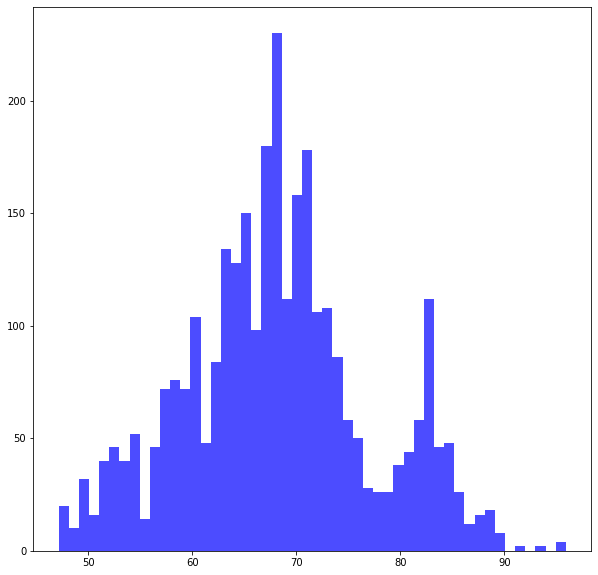

In [6]:
plt.figure(figsize=(10,10))
plt.hist(cropped_HR, bins=50, color='blue', alpha=0.7)
plt.show()

### 划分训练集，测试集

In [7]:
np.random.seed(1)
order = np.random.permutation(len(norm_signal))

num_train = int(len(norm_signal) * 0.9)
num_test = len(norm_signal) - num_train
print("{} training samples and {} testing samples.".format(num_train,num_test))

fold = 1
for i in range(fold):
    order = np.concatenate((order[num_test * i:],order[:num_test * i]))

x_train = norm_signal[order[:num_train]]
x_test = norm_signal[order[num_train:]]
y_train = norm_HR[order[:num_train]]
y_test = norm_HR[order[num_train:]]
print("x_train shape:{}\ty_train:shape:{}".format(x_train.shape,y_train.shape))
print("x_test shape:{}\ty_test:shape:{}".format(x_test.shape,y_test.shape))

2755 training samples and 307 testing samples.
x_train shape:(2755, 5, 200)	y_train:shape:(2755,)
x_test shape:(307, 5, 200)	y_test:shape:(307,)


### 观察信号的波形

Ground truth heart rate: 82.98875
Normalized ground truth heart rate: 0.39080681818181817


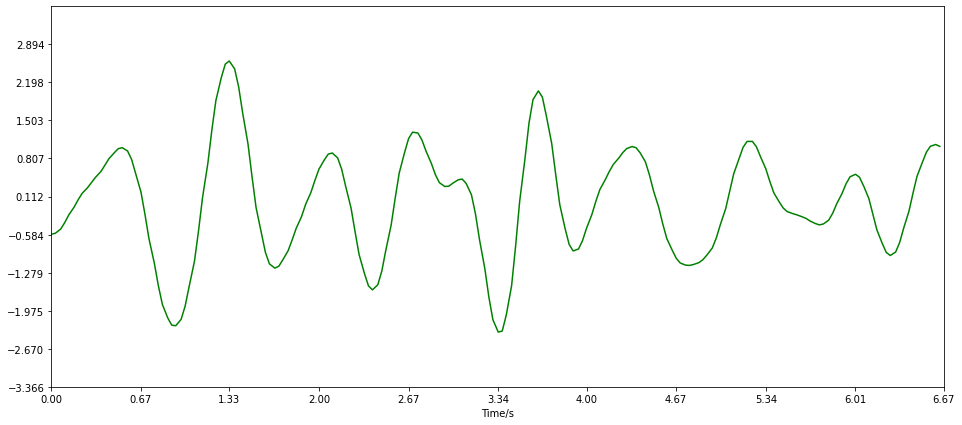

In [8]:
idx = 200
print("Ground truth heart rate: {}\nNormalized ground truth heart rate: {}".format(cropped_HR[idx],norm_HR[idx]))
show_signal(norm_signal[idx,0,:],fps)

### 创建tf.dataset对象

In [9]:
training_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
testing_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
print("Training dataset:",training_dataset.element_spec)
print("Testing dataset:",testing_dataset.element_spec)

Training dataset: (TensorSpec(shape=(5, 200), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))
Testing dataset: (TensorSpec(shape=(5, 200), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))


In [10]:
def anomaly_filter(x,y):
    """
       去除心率信号异常的样本
       params:
       x:shape:(200,5)
       y:shape:()
    """
    return True if y < 0.999 else False
    
training_dataset = training_dataset.filter(anomaly_filter)
testing_dataset = testing_dataset.filter(anomaly_filter)

training_dataset.shuffle(10000)
training_dataset = training_dataset.batch(64)
testing_dataset = testing_dataset.batch(64)

## 构建网络

In [11]:
model = HR_network(norm_signal.shape[1:],'RNN')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reshape_input (InputLayer)      [(None, 5, 200)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 5, 200, 1)    0           reshape_input[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 100, 16)   64          reshape[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5, 100, 16)   64          conv2d[0][0]                     
____________________________________________________________________________________________

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss='mse',metrics=["mae","mape"])

In [13]:
if not os.path.exists("./model_checkpoints"):
    os.mkdir("./model_checkpoints")

checkpoint_best = ModelCheckpoint('./model_checkpoints/loss_{loss:.4f}_val_loss_{val_loss:.4f}.h5',monitor='loss',verbose=1,
                                  save_best_only=True,save_weights_only=True)
early_stopping = EarlyStopping(monitor='loss',verbose=1,patience=50)
reduce_lr = ReduceLROnPlateau(monitor='loss',factor=0.5,patience=15,verbose=1)

## 模型训练  
### 权重保存在model_checkpoints文件夹下

In [14]:
history = model.fit(training_dataset,validation_data=testing_dataset,callbacks=[checkpoint_best,early_stopping,reduce_lr],
                    epochs=300)

### 绘制学习率曲线

In [14]:
def Plot_Learning_Curve(history,metric_name,save=False):
    plt.plot(history.history[metric_name])
    plt.plot(history.history['val_{}'.format(metric_name)])
    plt.title('{} vs. epochs'.format(metric_name.title()))
    plt.ylabel(metric_name.title())
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    if save:
        plt.savefig("./Plot-Analysis/Learning_Curve/Learning_Curve_{}/".format(dataset_source),dpi=300)
    plt.show()

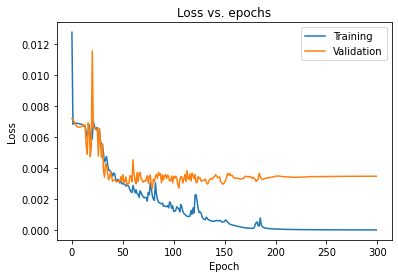

In [169]:
Plot_Learning_Curve(history,'loss',save=False)

### 保存训练的过程

In [25]:
with open('./Plot-Analysis/Learning_Curve/Learning_Curve_{}/Histroy-{}-CNN-LSTM.txt'.format(dataset_source,dataset_source),'w') as f:
    f.write(str(history.history))

## 结果分析：Bland-Altman图一致性分析，散点图回归分析

In [15]:
def denormalize_HR(batch_HR):
    return batch_HR * 110 + 40

def Linear_Fit(data1,data2):
    z1 = np.polyfit(data1, data2, 1)  #一次多项式拟合，相当于线性拟合
    return z1

def Bland_Altman_Plot(data1, data2, save, save_filename, BAplot_show, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    pierr     = np.corrcoef(data1,data2)
    print("Pearson correlation coefficient:{}".format(pierr))
    print("Mean of the difference:{}\nStandard deviation of the difference:{}".format(md,sd))
    
    plt.cla()
    scatter_plot = plt.scatter(mean, diff, s=10 ,*args, **kwargs)
    h1 = plt.axhline(md,           color='gray', linestyle='-')
    h2 = plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    h3 = plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    
    plt.title('Bland-Altman Plot',fontsize=25)
    plt.xlim((min(mean)-5,max(mean)+5))
    plt.ylim((min(diff)-5,max(diff)+5))
    plt.xlabel('($\mathregular{HR_{gt}}$ + $\mathregular{HR_{est}}$)/2',fontsize=20)
    plt.ylabel('$\mathregular{HR_{gt}}$ - $\mathregular{HR_{est}}$',fontsize=20)
    plt.legend((h1,h2,h3),('mean','mean+1.96δ','mean-1.96δ'))
    
    if save:
        plt.tight_layout()
        plt.savefig("./Plot-Analysis/Bland-Altman Plot/Bland_Altman_Plot_{}_{}/".format(dataset_source,mode) + save_filename + ".jpg",dpi=300)
    
    if BAplot_show:
        plt.show()
        
def Scatter_Plot_Fit(data1,data2,save,save_filename,plot_show):
    data1 = np.asarray(data1)
    data2 = np.asarray(data2)
    
    plt.cla()
    scatter_plot = plt.scatter(data1, data2, c = 'blue', alpha = 0.5, s = 5)
    
    plt.title('Scatter Plot',fontsize=25)
    plt.xlim((min(data1)-5,max(data1)+5))
    plt.ylim((min(data2)-5,max(data2)+5))
    plt.xlabel('$\mathregular{HR_{gt}}$',fontsize=20)
    plt.ylabel('$\mathregular{HR_{est}}$',fontsize=20)
    
    k,b = Linear_Fit(data1,data2)
    x = np.arange(min(data1)-2.5,max(data1)+2.5,1)
    y = k * x + b
    plt.plot(x,y,'r-')
    
    if save:
        plt.tight_layout()
        plt.savefig("./Plot-Analysis/Scatter Plot/Scatter_Plot_{}_{}/".format(dataset_source,mode) + save_filename + ".jpg",dpi=300)
    
    if plot_show:
        plt.show()

def Visualization(model,dataset,BAplot_show,Scaplot_show,save,save_filename,example_show,num_example):
    #  网络预测值
    y_out = model.predict(dataset)   #  shape:(num_test,1)
    
    #  如果数据集还没有batch化，则batch划分一下
    if len(dataset.element_spec[0].shape) == 2:
        dataset = dataset.batch(64)
        print(dataset.element_spec)
    
    #  实际值
    y_test = []
    for x,y in dataset.as_numpy_iterator():
        y_test.append(y)
    y_test = np.concatenate(y_test)
    
    #  转化为心率值
    HR_guessed = denormalize_HR(np.squeeze(y_out))
    HR_gt = denormalize_HR(y_test)
    
    #  给出一些例子
    if example_show:
        idx = np.random.choice(np.arange(len(y_test)),num_example,replace=False)

        print("The ground truth HR is:\t        The inferred HR is:")
        for gt,guessed in zip(HR_gt[idx],HR_guessed[idx]):
            print("{: <24.6f}\t{:.6f}".format(gt,guessed))
            
    #  绘制Bland_Altman统计图
    Bland_Altman_Plot(HR_gt,HR_guessed,save,save_filename,BAplot_show)
    Scatter_Plot_Fit(HR_gt,HR_guessed,save,save_filename,Scaplot_show)

In [16]:
HR_test_model = HR_network(input_shape=norm_signal.shape[1:])  #  eg.input_shape:batch*5*200
HR_test_model.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss='mse',metrics=["mae","mape"])
HR_test_model.load_weights('./model_checkpoints/candidate_model/LSTM-ECNU/loss_0.0021_val_loss_0.0027.h5')

In [18]:
HR_test_model.evaluate(training_dataset)

     44/Unknown - 1s 17ms/step - loss: 0.0022 - mae: 0.0341 - mape: 16.0467

[0.002231710347008299, 0.034120668, 16.046667]

The ground truth HR is:	        The inferred HR is:
72.787500               	65.401001
74.717500               	75.162613
80.962500               	76.679543
64.000000               	72.974045
87.891250               	69.233238
65.961250               	64.155365
51.237500               	52.208340
65.663750               	69.071297
67.516250               	70.455841
71.000000               	72.714760
67.392500               	62.801292
62.842500               	60.638199
57.641250               	68.277611
89.303750               	82.189346
70.117500               	64.624748
65.033750               	68.090019
51.216250               	54.619026
54.192500               	58.983227
82.397500               	81.864868
79.208750               	73.704292
Pearson correlation coefficient:[[1.         0.81484393]
 [0.81484393 1.        ]]
Mean of the difference:0.2544261469624652
Standard deviation of the difference:5.2106799739134715


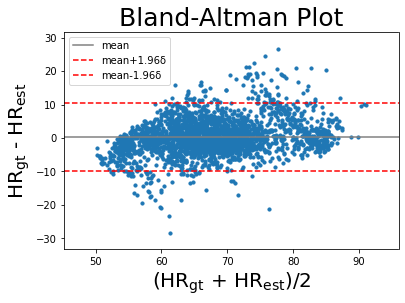

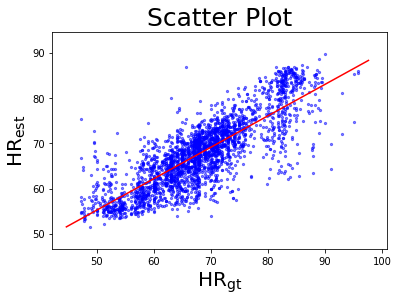

In [14]:
Visualization(HR_test_model,training_dataset,True,True,False,
              "loss_0.0021_val_loss_0.0027",example_show=True,num_example=20)

### 保存结果图

In [19]:
mode = 'Test'

HR_test_model = HR_network(input_shape=norm_signal.shape[1:])  #  eg.input_shape:batch*5*200
HR_test_model.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss='mse',metrics=["mae","mape"])

basedir = "./model_checkpoints/candidate_model/LSTM-{}".format(dataset_source)
for dirpath,dirnames,filenames in os.walk(basedir):
    for file in filenames:
        save_filename = file[:-3]
        HR_test_model.load_weights(os.path.join(basedir,file))
        
        if mode == 'Train':
            Visualization(HR_test_model,training_dataset,False,False,True,save_filename,example_show=False,num_example=20)
        elif mode == 'Test':
            Visualization(HR_test_model,testing_dataset,False,False,True,save_filename,example_show=False,num_example=20)